# Procesar la imagen #

El primer paso es procesar la imagen para obtener los coeficientes. Los pasos a seguir son los siguientes:
- Recortar la imagen para que sus dimensiones sean múltiplos de 8.
- Para cada bloque de 8x8 de una imagen:
    - Calcular la transformada discreta del coseno (coeficientes de la DCT).
    - Realizar una cuantificación de la transformada: los coeficientes de la DCT cuantificados deben seguir la ley de Benford. La cuantificación surge de redondear al entero más cercano el resultado de dividir un bloque entre una matriz de cuantificación. https://cs.stanford.edu/people/eroberts/courses/soco/projects/data-compression/lossy/jpeg/coeff.htm
- Obtener la lista de coeficientes resultante de iterar la matriz de coeficientes en modo zig-zag: el zig-zag recorre primero los coeficientes más importantes (baja frecuencia) y deja los menos relevantes al final (alta frecuencia). Al haber realizado la cuantificación, los primeros valores de la lista serán enteros distintos de 0 y los últimos serán, en su mayoría, 0.

Ejemplo modo zig-zag:

\begin{equation*}
\begin{pmatrix}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9
\end{pmatrix}
\rightarrow [1, 2, 4, 7, 5, 3, 6, 8, 9]
\end{equation*}

El siguiente código proporciona métodos para recortar la imagen, para hallar la DCT de un bloque, realizar la cuantificación de la transformada de un bloque y calcular una lista de coeficientes en modo zig-zag.

In [1]:
# imports
import torch
import cv2
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import os

In [2]:
# torch configuration
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.set_default_device(device)

Using cuda device


In [3]:
# Constants

BLOCK_SIZE = 8

EPSILON = 1e-6

BASE_QUANTIZATION_MATRIX = torch.tensor([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ], dtype=torch.float, device=device)

ZIGZAG_INDICES = torch.tensor([
        [0, 1, 5, 6, 14, 15, 27, 28],
        [2, 4, 7, 13, 16, 26, 29, 42],
        [3, 8, 12, 17, 25, 30, 41, 43],
        [9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]
    ], dtype=torch.long, device=device).flatten()

In [4]:
def crop_image(image, block_size):
    """
    Crop image to a size that is a multiple of block_size

    Parameters:
    - image (torch.Tensor): input image
    - block_size (int): block size

    Returns:
    - torch.Tensor: cropped image
    """
    
    h, w = image.shape[-2:]
    h_new = h - h % block_size
    w_new = w - w % block_size
    return image[..., :h_new, :w_new]

# https://github.com/zh217/torch-dct/blob/master/torch_dct/_dct.py
def dct_fft_impl(v):
    return torch.view_as_real(torch.fft.fft(v, dim=1))

def dct(x):
    """
    Compute 1D Discrete Cosine Transform (DCT-II) using FFT.
    """
    x_shape = x.shape
    N = x_shape[-1]
    x = x.contiguous().view(-1, N)

    v = torch.cat([x[:, ::2], x[:, 1::2].flip([1])], dim=1)

    Vc = dct_fft_impl(v)

    k = - torch.arange(N, dtype=x.dtype, device=x.device)[None, :] * np.pi / (2 * N)
    W_r = torch.cos(k)
    W_i = torch.sin(k)

    V = Vc[:, :, 0] * W_r - Vc[:, :, 1] * W_i
    V[:, 0] /= np.sqrt(N) * 2 # norm='ortho'
    V[:, 1:] /= np.sqrt(N / 2) * 2 # norm='ortho'

    V = 2 * V.view(*x_shape)

    return V

def compute_dct(block):
    """
    Compute DCT of an 8x8 block

    Parameters:
    - block (torch.Tensor): input 8x8 block

    Returns:
    - torch.Tensor: DCT coefficients
    """
    X1 = dct(block)
    X2 = dct(X1.transpose(-1, -2))
    return X2.transpose(-1, -2)
    

def get_quantization_matrix(quality):
    """
    Get quantization matrix for a given quality level

    Parameters:
    - quality (int): quality level

    Returns:
    - torch.Tensor: quantization matrix
    """

    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality

    quantization_matrix = ((BASE_QUANTIZATION_MATRIX * scale + 50) / 100).int()

    quantization_matrix = torch.clamp(quantization_matrix, min=1, max=255)

    return quantization_matrix

def quantize(block, quant_matrix):
    """
    Quantize an 8x8 block

    Parameters:
    - block (numpy.ndarray): input 8x8 block
    - quant_matrix (torch.Tensor): quantization matrix

    Returns:
    - torch.Tensor: quantized block
    """
    
    return torch.round(block / quant_matrix)

def zigzag_order(block):
    """
    Traverse a 2D array in zigzag order

    Parameters:
    - block (torch.Tensor): input 2D array

    Returns:
    - torch.Tensor: flattened elements in zigzag order
    """

    return block.flatten()[ZIGZAG_INDICES]


In [5]:
########################
# Test code
########################

path = "dummy-images/natural/natural-1.jpg"

# Load image and convert to grayscale
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

image = torch.tensor(image, dtype=torch.float, device=device)

image = crop_image(image, BLOCK_SIZE)

block = image[:8, :8]

Q_50 = get_quantization_matrix(50)
print("------- Q_50 -------")
print(Q_50)
print()

print("------- Block -------")
print(block)
print()

# Compute DCT of the block
dct_block = compute_dct(block)
print("------- DCT Block -------")
print(dct_block)
print()

# Quantize the block
quant_block = quantize(dct_block, Q_50)
print("------- Quantized Block -------")
print(quant_block)
print()

# Flatten the block in zigzag order
print("------- Zigzag Block -------")
zigzag_block = zigzag_order(quant_block)
print(zigzag_block)
print()


------- Q_50 -------
tensor([[ 16,  11,  10,  16,  24,  40,  51,  61],
        [ 12,  12,  14,  19,  26,  58,  60,  55],
        [ 14,  13,  16,  24,  40,  57,  69,  56],
        [ 14,  17,  22,  29,  51,  87,  80,  62],
        [ 18,  22,  37,  56,  68, 109, 103,  77],
        [ 24,  35,  55,  64,  81, 104, 113,  92],
        [ 49,  64,  78,  87, 103, 121, 120, 101],
        [ 72,  92,  95,  98, 112, 100, 103,  99]], device='cuda:0',
       dtype=torch.int32)

------- Block -------
tensor([[139., 144., 146., 146., 147., 149., 149., 149.],
        [143., 147., 148., 147., 148., 149., 148., 148.],
        [146., 148., 149., 149., 150., 150., 150., 151.],
        [145., 146., 146., 147., 148., 148., 148., 150.],
        [150., 150., 150., 150., 150., 150., 149., 151.],
        [149., 149., 148., 148., 149., 148., 148., 149.],
        [148., 149., 149., 149., 150., 150., 150., 151.],
        [147., 148., 148., 147., 149., 149., 149., 149.]], device='cuda:0')

------- DCT Block -------
ten

# Obtener todos los coeficientes de una imagen #

El siguiente paso es hallar todos los coeficientes $c_{n,\Delta}(k)$. Cada $c_{n,\Delta}(k)$ representa el coeficiente en la $n$-ésima frecuencia en modo zig-zag obtenida del $k$-ésimo bloque de la imagen y cuantificado con paso $\Delta$.

Para ello, se guardará en una matriz de dimensiones $K \times Q \times 64$, donde $K$ es el número de bloques de $8 \times 8$ en el que se ha dividido la imagen, $Q$ es el número de cuantificaciones realizadas y $64$ indica el número de elementos que tiene una lista al aplicarle zig-zag a un bloque.

In [6]:
def get_all_coefs(image, quant_matrices):
    """
    Compute DCT coefficients of an image more efficiently.

    Parameters:
    - image (torch.Tensor): input image
    - quant_matrices (list of torch.Tensor): list of quantization matrices
    
    Returns:
    - torch.Tensor: DCT coefficients (K, Q, BLOCK_SIZE*BLOCK_SIZE)
    """

    cropped_image = crop_image(image, BLOCK_SIZE)

    # Get 8x8 blocks using unfold (better than a loop)
    blocks = cropped_image.unfold(0, BLOCK_SIZE, BLOCK_SIZE).unfold(1, BLOCK_SIZE, BLOCK_SIZE)
    K = blocks.shape[0] * blocks.shape[1]  # Número total de bloques
    Q = len(quant_matrices)  # Número de matrices de cuantización

    # Organize everything in a block tensor 
    blocks = blocks.contiguous().view(K, BLOCK_SIZE, BLOCK_SIZE) # (K, 8, 8)

    # Apply DCT
    dct_blocks = torch.vmap(compute_dct)(blocks)

    # Convert matrices list into a tensor
    quant_matrices = torch.stack(quant_matrices)  # (Q, 8, 8)

    # Apply quantization to blocks
    quantized_blocks = torch.round(dct_blocks.unsqueeze(1) / quant_matrices)  # (K, Q, 8, 8)

    # Get frequencies in zig-zag order
    coefs = quantized_blocks.flatten(2)[:, :, ZIGZAG_INDICES]

    return coefs  # (K, Q, 64)

In [7]:
# Load image and convert to grayscale
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image = torch.tensor(image, dtype=torch.float, device=device)

# Define quantization matrices for quality factors 50, 80 and 90
Q_50 = get_quantization_matrix(50)
Q_80 = get_quantization_matrix(80)
Q_90 = get_quantization_matrix(90)

quant_matrices = [Q_50, Q_80, Q_90]

c = get_all_coefs(image, quant_matrices)

print("------- c_0_0(0) -------")
print(c[0, 0, 0])
print()

print("------- c_0_1(2) -------")
print(c[2, 1, 0]) # Note that the order of the indices is inverted
print()

print("------- coefs -------")
print(c)
print()

------- c_0_0(0) -------
tensor(74., device='cuda:0')

------- c_0_1(2) -------
tensor(201., device='cuda:0')

------- coefs -------
tensor([[[ 74.,  -1.,  -0.,  ...,  -0.,   0.,  -0.],
         [198.,  -2.,  -0.,  ...,  -0.,   0.,  -0.],
         [395.,  -4.,  -0.,  ...,  -0.,   0.,  -0.]],

        [[ 75.,  -0.,   0.,  ...,  -0.,  -0.,  -0.],
         [200.,  -0.,   0.,  ...,  -0.,  -0.,  -0.],
         [400.,  -0.,   0.,  ...,  -0.,  -0.,  -0.]],

        [[ 75.,  -0.,  -0.,  ...,  -0.,  -0.,  -0.],
         [201.,  -1.,  -0.,  ...,  -0.,  -0.,  -0.],
         [402.,  -2.,  -0.,  ...,  -0.,  -0.,  -0.]],

        ...,

        [[ 89.,  -1.,   0.,  ...,   0.,   0.,   0.],
         [236.,  -2.,   0.,  ...,   0.,   0.,   0.],
         [473.,  -5.,   0.,  ...,   0.,   0.,   0.]],

        [[ 90.,  -1.,   0.,  ...,   0.,   0.,   0.],
         [240.,  -2.,   0.,  ...,   0.,   0.,   0.],
         [480.,  -3.,   0.,  ...,   0.,   0.,   0.]],

        [[ 92.,  -1.,  -0.,  ...,  -0.,   0.,  -

# Primer dígito significativo #

Realizar el código para la fórmula:

$d_{b,n,\Delta}(k) = \lfloor \dfrac{\mid c_{n,\Delta}(k) \mid}{b^{\lfloor \text{log}_b \mid c_{n,\Delta}(k) \mid \rfloor} } \rfloor$

Donde:
- $d_{b,n,\Delta}(k)$ es el primer dígito significante en base b en la n-ésima frecuencia en modo zig-zag obtenida del k-ésimo bloque y cuantificado con paso $\Delta$.
- $c_{n,\Delta}(k)$ es el coeficiente en la n-ésima frecuencia en modo zig-zag obtenida del k-ésimo bloque y cuantificado con paso $\Delta$.

Una vez se ha obtenido la matriz de coeficientes, se puede calcular la matriz de primeros dígitos añadiéndole la dimensión $B$, siendo ésta el número de bases a utilizar. La matriz resultante será de dimensiones $K \times Q \times 64 \times B$.

In [8]:
def first_significant_digit(values, base):
    """
    Computes the first significant digit (FD) of a given values in a specified base.
    
    Parameters:
    - values (torch.Tensor): DCT coefficient values.
    - base (int): The numerical base.
    
    Returns:
    - torch.Tensor: The first significant digit of the input values in the given base.
    """
    values = torch.abs(values)
    
    fd = torch.zeros_like(values, dtype=torch.uint8, device=device)
    
    # Select non zero values
    mask = values != 0
    nonzero_values = values[mask]
    
    # Apply the formula only to non zero values
    exponent = torch.floor(torch.log(nonzero_values) / torch.log(base))
    fd_nonzero = torch.floor(nonzero_values / (base ** exponent)).to(torch.uint8)
    
    fd[mask] = fd_nonzero
    
    return fd


def get_all_digits(coefs, bases):
    """
    Compute the first significant digit of all DCT coefficients in a given base.
    
    Parameters:
    - coefs (torch.Tensor): DCT coefficients.
    - bases (list): List of numerical bases.
    
    Returns:
    - torch.Tensor: First significant digits of all DCT coefficients in the given bases.
    """
    
    K, Q, _ = coefs.shape
    B = len(bases)
    digits = torch.zeros((K, Q, BLOCK_SIZE*BLOCK_SIZE, B), dtype=torch.uint8, device=device)

    bases_tensor = torch.as_tensor(bases, dtype=torch.int32, device=device)
    for l, base in enumerate(bases_tensor):
        digits[...,l] = first_significant_digit(coefs,base)
    
    return digits


In [9]:
d = get_all_digits(c, [10, 20, 40])
print("------- d_0_0_0(0) -------")
print(d[0, 0, 0, 0])
print()

print("------- d_1_5_1(3) -------")
print(d[3, 1, 5, 1]) # Note that the order of the indices is inverted
print()

print("------- digits -------")
print(d)
print()


------- d_0_0_0(0) -------
tensor(7, device='cuda:0', dtype=torch.uint8)

------- d_1_5_1(3) -------
tensor(0, device='cuda:0', dtype=torch.uint8)

------- digits -------
tensor([[[[ 7,  3,  1],
          [ 1,  1,  1],
          [ 0,  0,  0],
          ...,
          [ 0,  0,  0],
          [ 0,  0,  0],
          [ 0,  0,  0]],

         [[ 1,  9,  4],
          [ 2,  2,  2],
          [ 0,  0,  0],
          ...,
          [ 0,  0,  0],
          [ 0,  0,  0],
          [ 0,  0,  0]],

         [[ 3, 19,  9],
          [ 4,  4,  4],
          [ 0,  0,  0],
          ...,
          [ 0,  0,  0],
          [ 0,  0,  0],
          [ 0,  0,  0]]],


        [[[ 7,  3,  1],
          [ 0,  0,  0],
          [ 0,  0,  0],
          ...,
          [ 0,  0,  0],
          [ 0,  0,  0],
          [ 0,  0,  0]],

         [[ 2,  9,  4],
          [ 0,  0,  0],
          [ 0,  0,  0],
          ...,
          [ 0,  0,  0],
          [ 0,  0,  0],
          [ 0,  0,  0]],

         [[ 4,  1,  9]

# PDF para los primeros dígitos #

La función de densidad de probabilidad es la siguiente:

$\hat{p}(d) = \dfrac{1}{K} \sum_{k=1}^{K} \textbf{1}_x(d(k)), d \in \{1,2,...,b-1\}$

Donde:

\begin{align*}
\textbf{1}_x(y) = 
\left\{
    \begin {aligned}
         & 1 \quad & x = y \\
         & 0 \quad & otherwise                  
    \end{aligned}
\right.
\end{align*}

Se utiliza $\hat{p}(d)$ en lugar de $\hat{p}_{b,n,\Delta}(d)$ por temas de compacidad.

In [10]:
def get_pdf_est(digits, b, n, delta, base):
    """
    Compute the probability density function of the first significant digits of DCT coefficients.
    
    Parameters:
    - digits (torch.Tensor): First significant digits of DCT coefficients.
    - b (int): base index.
    - n (int): frequency index.
    - delta (float): delta index.
    - base (int): Numerical base.
    
    Returns:
    - p_est (dict): Probability density function of the first significant digits of DCT coefficients.
    """
    
    p_est = {i: 0 for i in range(1, base)}

    K = digits.shape[0]

    # Get the relevant slice of the tensor 'digits' for the specific (n, delta, b)
    relevant_digits = digits[:, delta, n, b]

    # Count occurrences of each digit using torch's bincount (efficient counting)
    counts = torch.bincount(relevant_digits[relevant_digits > 0], minlength=base)[1:]

    # Update p_est with counts
    p_est.update({i: counts[i-1].item() for i in range(1, base)})

    # Compute total non-zero elements (avoid division by zero)
    total = counts.sum().item()
    for i in range(1,base):
        p_est[i] /= K
        if p_est[i] == 0:
            p_est[i] = EPSILON
    
    # Normalize the probabilities
    total = sum(p_est.values())
    for i in range(1, base):
        p_est[i] /= total

    return p_est

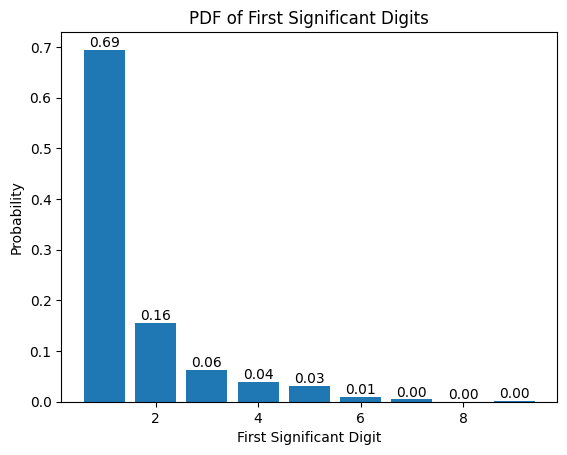

In [11]:
p_est = get_pdf_est(d, 0, 5, 2, 10) # b = 0, n = 5, delta = 2, base = 10

# Display PDF
bars = plt.bar(p_est.keys(), p_est.values())
plt.xlabel("First Significant Digit")
plt.ylabel("Probability")
plt.title("PDF of First Significant Digits")

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

# Mínimos cuadrados #

Para clasificar correctamente las imágenes, hay que comparar la función de densidad de probabilidad obtenida anteriormente con la ecuación generalizada de Benford:

$p(d) = \beta \text{ log}_{b} (1 + \dfrac{1}{\gamma + d^\delta})$

Para estimar los párametros $\beta, \gamma$ y $\delta$ hay que resolver un problema de mínimos cuadrados:

$p_{b,n,\Delta}^{\text{fit}} = \underset{p}{\text{arg min}} \sum_{d=1}^{b-1} (\hat{p}_{b,n,\Delta}(d) - p(d)) $

In [12]:
def benford(d, beta, gamma, delta, base):
    """Generalized Benford's Law function."""
    denom = np.clip(gamma + d**delta, EPSILON, None)  # Avoid division by zero
    return beta * (np.log(1 + 1 / denom) / np.log(base))

def residuals(params, d, p):
    """Compute residuals for curve fitting."""
    return benford(d, *params, len(d) + 1) - p

def jacobian(params, d, p):
    beta, gamma, delta = params
    base = len(d) + 1

    J_beta = (np.log(1 - 1 / (gamma - d**delta)) / np.log(base))
    J_gamma = beta / (np.log(base) * (d**delta - gamma) * (d**delta - gamma + 1))
    J_delta = (base * d**delta ** np.log(d)) / (np.log(base) * (d**delta - gamma) * (d**delta - gamma + 1))

    return np.vstack((J_beta, J_gamma, J_delta)).T

def get_pdf_fit(p_est):
    """
    Fit Benford's Law to the estimated probability density function.
    
    Parameters:
    - p_est (dict): Estimated probability density function (keys: digits, values: probabilities).
    
    Returns:
    - p_fit (dict): Fitted probability density function.
    """
    
    p_fit = {}
    
    d_values = np.array(list(p_est.keys()))
    p_values = np.array(list(p_est.values()))

    base = len(d_values) + 1

    initial_guess = [1, 1, 1]

    # popt = opt.least_squares(residuals, initial_guess, jac=jacobian, args=(d_values, p_values))
    popt = opt.least_squares(residuals, initial_guess, args=(d_values, p_values))

    for i in d_values:
        p_fit[i] = benford(i, *popt.x, base)
        if p_fit[i] == 0:
            p_fit[i] = EPSILON  # Avoid division by zero

    # Normalize PDF
    p_fit_sum = sum(p_fit.values())
    for i in d_values:
        p_fit[i] /= p_fit_sum

    return p_fit

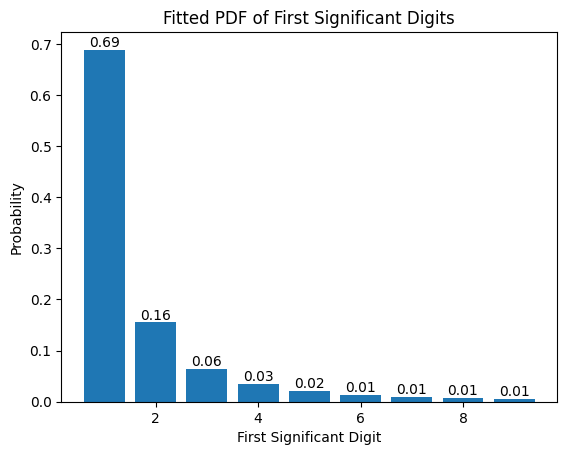

In [13]:
p_fit = get_pdf_fit(p_est)

# Display PDF
bars = plt.bar(p_fit.keys(), p_fit.values())
plt.xlabel("First Significant Digit")
plt.ylabel("Probability")
plt.title("Fitted PDF of First Significant Digits")

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

# Divergencias #

Una vez obtenida la distribución $p^{\text{fit}}$, hay que compararla con $\hat{p}$. La aptitud se puede medir usando funciones de divergencia, como puede ser la de Jensen-Shanon:

$D^{\text{JS}} (\hat{p} \mid p) = D^{\text{KL}} (\hat{p} \mid p) + D^{\text{KL}} (p \mid \hat{p})$,

que es una versión simetrizada de la divergencia de Kullback-Leibler:

$D^{\text{KL}} (\hat{p} \mid p) = \sum_{d=1}^{b-1} \hat{p}(d) \text{ log}\dfrac{\hat{p}(d)}{p(d)} $

En ocasiones es preferible utilizar divergencia simetrizada de Renyi, ya que $D^{\text{JS}}$ puede ser inestable en pdfs sesgadas:

$D^{\text{R}}_{\alpha} (\hat{p} \mid p) = \dfrac{1}{1-\alpha} (\text{log } S_{\alpha} (\hat{p}, p) + \text{log } S_{\alpha} (p,\hat{p}))$,

también se puede usar la divergencia simetrizada de Tsallis:

$D^{\text{T}}_{\alpha} (\hat{p} \mid p) = \dfrac{1}{1-\alpha} (2 - S_{\alpha} (\hat{p}, p) - S_{\alpha} (p,\hat{p}))$,

donde

$S_{\alpha} (q, p) = \sum_{d=1}^{b-1} \dfrac{q(d)^\alpha}{p(d)^{\alpha - 1}}$



In [14]:
def js_divergence(p, q):
    """
    Compute the Jensen-Shannon divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Jensen-Shannon divergence between p and q.
    """
    
    return kl_divergence(p, q) + kl_divergence(q, p)

def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Kullback-Leibler divergence between p and q.
    """
    
    kl = 0
    
    for key in p.keys():
        kl += p[key] * np.log(p[key] / q[key])
    
    return kl

def r_divergence(p, q, alpha):
    """
    Compute the Renyi divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Renyi divergence between p and q.
    """
    
    r = 1 / (1 - alpha) * (np.log(s_function(p, q, alpha)) + np.log(s_function(q, p, alpha)))
    
    return r

def t_divergence(p, q, alpha):
    """
    Compute the Tsallis divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Tsallis divergence between p and q.
    """
    
    t = 1 / (1 - alpha) * (2 - s_function(p, q, alpha) - s_function(q, p, alpha))
    
    return t

def s_function(q, p, alpha):
    """
    Compute weighted sum that combines two probability distributions

    Parameters:
    - q (dict): First probability distribution.
    - p (dict): Second probability distribution.
    - alpha (float): Weighting factor.

    Returns:
    - float: Weighted sum of the two probability distributions.
    """

    s = 0

    for key in q.keys():
        s += (q[key] ** alpha) / (p[key] ** (alpha - 1))

    return s

In [15]:
js = js_divergence(p_est, p_fit)
r = r_divergence(p_est, p_fit, 0.5)
t = t_divergence(p_est, p_fit, 0.5)

print(f"Jensen-Shanon Divergence: {js:.4f}")
print(f"Renyi Divergence: {r:.4f}")
print(f"Tsallis Divergence: {t:.4f}")

Jensen-Shanon Divergence: 0.0636
Renyi Divergence: -0.0210
Tsallis Divergence: 0.0209


# Vector de características #

Considerando un conjunto $B$ de bases, un conjunto $N$ de frecuencias y un conjunto $J$ de factores de calidad de JPEG (correspondiente a cada uno de las matrices de cuantificación $\Delta$), se puede obtener un vector de características concatenando todas las divergencias de la siguiente manera:

$\Phi_{B,N,J} = [D_{b,n,\Delta}^{\text{JS}}, D_{b,n,\Delta}^{\text{R}}, D_{b,n,\Delta}^{\text{T}}]$

El vector final tendrá tamaño $|B| \times |N| \times |J| \times 3$.

In [16]:
def get_feature_vector(image, bases, frequencies, quant_matrices):
    """
    Compute feature vectors of an image
    
    Parameters:
    - image (torch.Tensor): input image
    - bases (list): list of numerical bases
    - frequencies (list): list of frequency indices
    - quant_matrices (list): list of quantization matrices
    
    Returns:
    - torch.Tensor: feature vectors
    """
    
    coefs = get_all_coefs(image, quant_matrices)
    digits = get_all_digits(coefs, bases)
    
    feature_vectors = torch.zeros((len(bases), len(frequencies), len(quant_matrices), 3), dtype=torch.float32, device=device)

    for b, base in enumerate(bases):
        for n, frequency in enumerate(frequencies):
            for q, _ in enumerate(quant_matrices):
                p_est = get_pdf_est(digits, b, frequency, q, base)
                p_fit = get_pdf_fit(p_est)
                js = js_divergence(p_est, p_fit)
                r = r_divergence(p_est, p_fit, 0.5)
                t = t_divergence(p_est, p_fit, 0.5)
                feature_vectors[b, n, q] = torch.tensor([js,r,t], device=device)
    
    return feature_vectors

In [17]:
# Load image, convert to grayscale and crop
image = crop_image(cv2.imread(path, cv2.IMREAD_GRAYSCALE), 8)
image = torch.tensor(image, dtype=torch.float, device=device)

bases = [10, 20, 40]
frequencies = [2, 5, 8]
quant_matrices = [Q_50, Q_80, Q_90]

feature_vectors = get_feature_vector(image, bases, frequencies, quant_matrices)
print("------- Feature Vectors -------")
print(feature_vectors)

------- Feature Vectors -------
tensor([[[[ 0.0558, -0.0180,  0.0180],
          [ 0.0131, -0.0065,  0.0065],
          [ 0.0428, -0.0214,  0.0213]],

         [[ 0.0457, -0.0182,  0.0182],
          [ 0.0654, -0.0247,  0.0246],
          [ 0.0636, -0.0210,  0.0209]],

         [[ 0.0072, -0.0036,  0.0036],
          [ 0.0028, -0.0014,  0.0014],
          [ 0.0011, -0.0006,  0.0006]]],


        [[[ 0.0577, -0.0189,  0.0188],
          [ 0.1370, -0.0442,  0.0440],
          [ 0.0998, -0.0485,  0.0482]],

         [[ 0.0361, -0.0146,  0.0146],
          [ 0.0805, -0.0308,  0.0307],
          [ 0.1408, -0.0464,  0.0461]],

         [[ 0.0324, -0.0161,  0.0161],
          [ 0.0187, -0.0093,  0.0093],
          [ 0.0082, -0.0041,  0.0041]]],


        [[[ 0.0579, -0.0189,  0.0189],
          [ 0.1836, -0.0609,  0.0604],
          [ 0.4077, -0.1374,  0.1351]],

         [[ 0.0373, -0.0152,  0.0152],
          [ 0.0818, -0.0314,  0.0313],
          [ 0.1686, -0.0575,  0.0571]],

         [[ 

# Conseguir dataset #

Una vez conseguido el vector de características, hay que obtener un dataset. En este caso, se va a sacar un archivo csv donde cada fila corresesponde al vector de características de una imagen y el último elemento será la etiqueta de la imagen ('1' si es generada por IA y '0' en el caso contrario).

In [18]:
def process_and_save_images(folder_path, n_images, label, bases, frequencies, quant_matrices, filename):
    """
    Process and save feature vectors of a set of images to a CSV file one by one.

    Parameters:
    - folder_path (str): path to the folder containing the images.
    - n_images (int): number of images to process.
    - label (int): label of the images (1 if AI generated, 0 if not).
    - bases (list): list of numerical bases.
    - frequencies (list): list of frequency indices.
    - quant_matrices (list): list of quantization matrices.
    - filename (str): name of the CSV file.
    """
    # Get the image filenames
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    n_images = min(n_images, len(image_files))

    if n_images == 0:
        print("No images found in the specified folder.")
        return

    for i in range(n_images):
        image_path = os.path.join(folder_path, image_files[i])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        # Crop and convert to tensor
        image = crop_image(image, BLOCK_SIZE)
        image = torch.tensor(image, dtype=torch.float, device=device)

        try:
            # Extract features
            features = get_feature_vector(image, bases, frequencies, quant_matrices)
        except Exception as e:
            print(f"Error processing image: {image_path}, Error: {e}")
            continue

        # Convert to NumPy and flatten
        flattened_features = features.cpu().numpy().flatten()
        row = np.append(flattened_features, label)

        # Convert to DataFrame and save immediately
        df = pd.DataFrame([row])
        df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

    print(f"{n_images} images have been processed and saved to {filename}")

def generate_csv_header(divergences, bases, frequencies, qualities, filename):
    """
    Generate and save CSV header based on provided lists.
    """
    
    header = []

    for b in bases:
        for f in frequencies:
            for q in qualities:
                for d in divergences:
                    header.append(f"{d}_{b}_{f}_{q}")

    header.append("label")

    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)

        if list(df_existing.columns) != header:
            df_existing.columns = header
            df_existing.to_csv(filename, index=False, header=True)  # Sobrescribir con nuevo encabezado
    else:
        df = pd.DataFrame(columns=header)
        df.to_csv(filename, index=False, header=True)
        
    return header

In [19]:
divergences_str = ["js", "r", "t"]
bases_str = ["10", "20", "40"]
frequencies_str = ["2", "5", "8"]
qualities_str = ["50", "80", "90"]
filename = "features.csv"

csv_header = generate_csv_header(divergences_str, bases_str, frequencies_str, qualities_str, filename)

In [20]:
ruta_natural = "dummy-images/natural"
ruta_ia = "dummy-images/ia"

process_and_save_images(ruta_natural, 10, '0', bases, frequencies, quant_matrices, "features.csv")
process_and_save_images(ruta_ia, 10, '1', bases, frequencies, quant_matrices, "features.csv")

4 images have been processed and saved to features.csv
3 images have been processed and saved to features.csv
